# Quick Start PyTorch - MNIST

To run a Code Cell you can click on the `⏯ Run` button in the Navigation Bar above or type `Shift + Enter`

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../python')

from functions import *
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import ExponentialLR

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
from tqdm import *
import copy



import time



# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
SEED = 1
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

/global/home/users/njo/anaconda3/envs/gaia/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /global/home/users/njo/anaconda3/envs/gaia/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
#     transforms.ToTensor(), # ToTensor does min-max normalization. 
# ]), )

# test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
#     transforms.ToTensor(), # ToTensor does min-max normalization. 
# ]), )



# Download data without any transforms
train_raw = MNIST('../data', train=True, download=True)
test_raw = MNIST('../data', train=False, download=True)

# Convert train and test data to tensors
train_data = torch.stack([transforms.ToTensor()(image) for image, _ in train_raw])
test_data = torch.stack([transforms.ToTensor()(image) for image, _ in test_raw])

# Calculate mean and std
train_mean = torch.mean(train_data)
train_std = torch.std(train_data)

test_mean = torch.mean(test_data)
test_std = torch.std(test_data)

# Define transforms using calculated mean and std
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(train_mean,), std=(train_std,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(test_mean,), std=(test_std,))
])

# Create new datasets using the normalization calculated
train = MNIST('../data', train=True, download=True, transform=train_transform)
test = MNIST('../data', train=False, download=True, transform=test_transform)

# Now you can continue with creating your DataLoader, etc.


# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)







In [3]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

test_data = train.train_data
test_data = train.transform(test_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))


print('[Test]')
print(' - Numpy Shape:', test.test_data.cpu().numpy().shape)
print(' - Tensor Shape:', test.test_data.size())
print(' - min:', torch.min(test_data))
print(' - max:', torch.max(test_data))
print(' - mean:', torch.mean(test_data))
print(' - std:', torch.std(test_data))
print(' - var:', torch.var(test_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4241)
 - max: tensor(2.8215)
 - mean: tensor(3.0559e-08)
 - std: tensor(1.0000)
 - var: tensor(1.0000)
[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - min: tensor(-0.4241)
 - max: tensor(2.8215)
 - mean: tensor(3.0559e-08)
 - std: tensor(1.0000)
 - var: tensor(1.0000)


/global/home/users/njo/anaconda3/envs/gaia/lib/python3.8/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/global/home/users/njo/anaconda3/envs/gaia/lib/python3.8/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


## Model

In [4]:
from models import *

    
    


In [5]:
model_fc = Model()
params_fc = sum(p.numel() for p in model_fc.parameters())
print(f'Total number of parameters in FC model: {params_fc}')

model_cnn = SimpleCNN()
params_cnn = sum(p.numel() for p in model_cnn.parameters())
print(f'Total number of parameters in CNN model: {params_cnn}')

model_cnn = SimplestCNN()
params_cnn = sum(p.numel() for p in model_cnn.parameters())
print(f'Total number of parameters in CNN_smal model: {params_cnn}')


Total number of parameters in FC model: 795010
Total number of parameters in CNN model: 941526
Total number of parameters in CNN_smal model: 23466


In [6]:



model_perp=SimpleCNN()
# model_W=copy.deepcopy(model_perp)
if cuda:
    model_perp.cuda() # CUDA!
optimizer_perp = Adam_Perpendicular(model_perp.parameters(), lr=1e-2,weight_decay=1)
# optimizer_perp = optim.AdamW(model_perp.parameters(), lr=1e-4,weight_decay=10)






EPOCHS = 100


# Initialize lists to hold train and test losses per epoch
train_losses_per_epoch_perp = []
test_losses_per_epoch_perp = []

# Record the start time
start_time = time.time()

# Initialize the scheduler
# scheduler = CosineAnnealingLR(optimizer_perp, T_max=EPOCHS, eta_min=1e-5)
rate=10**(-3/EPOCHS)
scheduler = ExponentialLR(optimizer_perp, rate)

# Training loop
for epoch in range(EPOCHS):
    model_perp.train()
    train_loss_epoch = 0  # Variable to store the sum of batch losses
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Initialize gradients to zero
        optimizer_perp.zero_grad()

        # Forward pass
        y_pred = model_perp(data)

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        train_loss_epoch += loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer_perp.step()

    # Calculate the average training loss for this epoch and store
    train_losses_per_epoch_perp.append(train_loss_epoch / len(train_loader))

    # Evaluation
    model_perp.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            
            output = model_perp(data)
            test_loss += F.cross_entropy(output, target).item()
            pred = output.data.max(1)[1]
            correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader)
    test_losses_per_epoch_perp.append(test_loss)  # Store test loss
    accuracy = 100. * correct / len(test_loader.dataset)
    
    # Update learning rate
    scheduler.step()

    # Calculate runtime and expected time
    elapsed_time = time.time() - start_time
    expected_time = elapsed_time * EPOCHS / (epoch + 1)

    elapsed_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    expected_str = time.strftime("%H:%M:%S", time.gmtime(expected_time))

    # Update display for the epoch
    print(f'\rTrain Epoch: {epoch+1}/{EPOCHS}\tTrain Loss: {train_losses_per_epoch_perp[-1]:.6f}\tTest Loss: {test_loss:.4f}\tAccuracy: {accuracy:.2f}%\tElapsed Time: {elapsed_str}\tExpected Time: {expected_str}', end='')
print()


Train Epoch: 37/100	Train Loss: 0.037886	Test Loss: 0.0419	Accuracy: 98.77%	Elapsed Time: 00:01:34	Expected Time: 00:04:16

KeyboardInterrupt: 

In [34]:
model_W=SimplestCNN()

model_perp=copy.deepcopy(model_W)
if cuda:
    model_W.cuda() # CUDA!
# optimizer_W = AdamW_Perpendicular(model_W.parameters(), lr=1e-3,weight_decay=.01)
optimizer_W = optim.AdamW(model_W.parameters(), lr=1e-2,weight_decay=1)





EPOCHS = 100


# Initialize lists to hold train and test losses per epoch
train_losses_per_epoch_W = []
test_losses_per_epoch_W = []

# Record the start time
start_time = time.time()

# Initialize the scheduler
# scheduler = CosineAnnealingLR(optimizer_W, T_max=EPOCHS, eta_min=1e-5)
rate=10**(-3/EPOCHS)
scheduler = ExponentialLR(optimizer_W, rate)


# Training loop
for epoch in range(EPOCHS):
    model_W.train()
    train_loss_epoch = 0  # Variable to store the sum of batch losses
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Initialize gradients to zero
        optimizer_W.zero_grad()

        # Forward pass
        y_pred = model_W(data)

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        train_loss_epoch += loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer_W.step()

    # Calculate the average training loss for this epoch and store
    train_losses_per_epoch_W.append(train_loss_epoch / len(train_loader))

    # Evaluation
    model_W.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            
            output = model_W(data)
            test_loss += F.cross_entropy(output, target).item()
            pred = output.data.max(1)[1]
            correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader)
    test_losses_per_epoch_W.append(test_loss)  # Store test loss
    accuracy = 100. * correct / len(test_loader.dataset)
    
    # Update learning rate
    scheduler.step()

    # Calculate runtime and expected time
    elapsed_time = time.time() - start_time
    expected_time = elapsed_time * EPOCHS / (epoch + 1)

    elapsed_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    expected_str = time.strftime("%H:%M:%S", time.gmtime(expected_time))

    # Update display for the epoch
    print(f'\rTrain Epoch: {epoch+1}/{EPOCHS}\tTrain Loss: {train_losses_per_epoch_W[-1]:.6f}\tTest Loss: {test_loss:.4f}\tAccuracy: {accuracy:.2f}%\tElapsed Time: {elapsed_str}\tExpected Time: {expected_str}', end='')
print()

Train Epoch: 100/100	Train Loss: 0.032065	Test Loss: 0.0415	Accuracy: 98.75%	Elapsed Time: 00:04:18	Expected Time: 00:04:18


In [ ]:
model_W=SimplestCNN()
model_perp=copy.deepcopy(model_W)

# CUDA!
if cuda:
    model_W.cuda() 
    model_perp.cuda() 
    

# Set params
LR=1e-2
WD=.05
EPOCHS = 100
    
optimizer_W = optim.AdamW(model_W.parameters(), lr=LR,weight_decay=WD)
optimizer_perp = Adam_Perpendicular(model_perp.parameters(), lr=LR,weight_decay=WD)



# Scheduls
# CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min)
rate=10**(-3/EPOCHS)
scheduler_W = ExponentialLR(optimizer_W, rate)
scheduler_perp = ExponentialLR(optimizer_perp, rate)





# Initialize lists to hold train and test losses per epoch
# train_losses_per_epoch_W = []
# test_losses_per_epoch_W = []

# Initialize dictionries of things we want to keep
params_epochs={'train_W':[],'train_perp':[],'test_W':[],'test_perp':[],'accuracy_W':[],'accuracy_perp':[]}
l2_norm_last_batch_grad_W=0
l2_norm_last_batch_grad_perp=0


# Record the start time
start_time = time.time()



# Training loop
for epoch in range(EPOCHS):
    model_W.train()
    train_loss_epoch_W = 0  # Variable to store the sum of batch losses
    train_loss_epoch_perp = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Initialize gradients to zero
        optimizer_W.zero_grad()
        optimizer_perp.zero_grad()

        # Forward pass
        y_pred_W = model_W(data)
        y_pred_perp = model_perp(data)

        # Calculate loss
        loss_W = F.cross_entropy(y_pred_W, target)
        loss_perp = F.cross_entropy(y_pred_perp, target)
        train_loss_epoch_W += loss_W.item()
        train_loss_epoch_perp += loss_perp.item()
        
        # Backpropagation
        loss_W.backward()
        optimizer_W.step()
        loss_perp.backward()
        optimizer_perp.step()
    if epoch == EPOCHS - 1:
        for param in model_W.parameters():
            if param.grad is not None:
                l2_norm_last_batch_grad_W += torch.sum(param.grad ** 2)
        for param in model_perp.parameters():
            if param.grad is not None:
                l2_norm_last_batch_grad_perp += torch.sum(param.grad ** 2)

        l2_norm_last_batch_grad_W = torch.sqrt(l2_norm_last_batch_grad_W)
        l2_norm_last_batch_grad_perp = torch.sqrt(l2_norm_last_batch_grad_perp)



    # Calculate the average training loss for this epoch and store
    params_epochs['train_W']+=[train_loss_epoch_W / len(train_loader)]
    params_epochs['train_perp']+=[train_loss_epoch_perp / len(train_loader)]

    # Evaluation
    model_W.eval()
    model_perp.eval()
    test_loss_W = 0
    correct_W = 0
    test_loss_perp = 0
    correct_perp = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            
            output_W = model_W(data)
            test_loss_W += F.cross_entropy(output_W, target).item()
            pred_W = output_W.data.max(1)[1]
            correct_W += pred_W.eq(target.data).cpu().sum()
            
            output_perp = model_perp(data)
            test_loss_perp += F.cross_entropy(output_perp, target).item()
            pred_perp = output_perp.data.max(1)[1]
            correct_perp += pred_perp.eq(target.data).cpu().sum()

    test_loss_W /= len(test_loader)
    test_loss_perp /= len(test_loader)
    params_epochs['test_W']+=[test_loss_W]  # Store test loss
    params_epochs['test_perp']+=[test_loss_perp]
    
    accuracy_W = 100. * correct_W / len(test_loader.dataset)
    accuracy_perp = 100. * correct_perp / len(test_loader.dataset)
    accuracy_W
    params_epochs['accuracy_W']+=[accuracy_W]  # Store test accuracy
    params_epochs['accuracy_perp']+=[accuracy_perp]
    
    # Update learning rate
    scheduler_W.step()
    scheduler_perp.step()

    # Calculate runtime and expected time
    elapsed_time = time.time() - start_time
    expected_time = elapsed_time * EPOCHS / (epoch + 1)

    elapsed_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    expected_str = time.strftime("%H:%M:%S", time.gmtime(expected_time))

    # Update display for the epoch
    print(f"\rTrain Epoch: {epoch+1}/{EPOCHS}\tTrain Loss: {params_epochs['train_W'][-1]:.4f} | {params_epochs['train_perp'][-1]:.4f}\tTest Loss: {params_epochs['test_W'][-1]:.4f} | {params_epochs['test_perp'][-1]:.4f}\tAccuracy: {params_epochs['accuracy_W'][-1]:.2f}% | {params_epochs['accuracy_perp'][-1]:.2f}%\tElapsed Time: {elapsed_str}\tExpected Time: {expected_str}", end='')
print()



Train Epoch: 94/100	Train Loss: 0.0001 | 0.0001	Test Loss: 0.0635 | 0.0637	Accuracy: 98.82% | 98.82%	Elapsed Time: 00:04:00	Expected Time: 00:04:15

In [14]:
print(calculate_l2_norm(model_perp)**.5*WD, calculate_l2_norm(model_W)**.5*WD)

# l2_norm_last_batch_grad_W and l2_norm_last_batch_grad_perp now contain the L2 norm of the gradients for the last batch of the last epoch
print("L2 norm of last-batch gradient for model_W: ", l2_norm_last_batch_grad_W.item())
print("L2 norm of last-batch gradient for model_perp: ", l2_norm_last_batch_grad_perp.item())




0.565927426660723 0.5637246977450899
L2 norm of last-batch gradient for model_W:  0.7709131240844727
L2 norm of last-batch gradient for model_perp:  0.7725787162780762


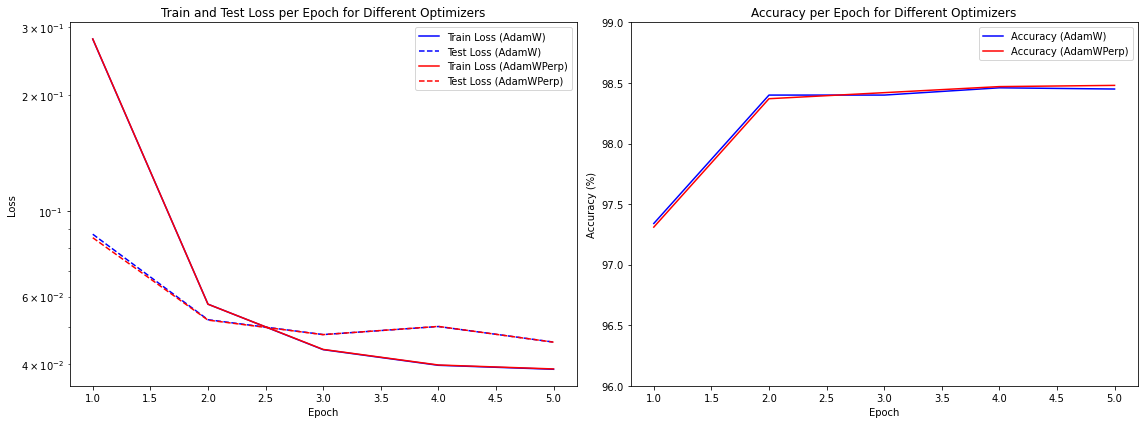

In [15]:
# Initialize figure and axis
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# First subplot for Loss
axs[0].plot(range(1, EPOCHS + 1), params_epochs['train_W'], label='Train Loss (AdamW)', color='b', linestyle='-')
axs[0].plot(range(1, EPOCHS + 1), params_epochs['test_W'], label='Test Loss (AdamW)', color='b', linestyle='--')
axs[0].plot(range(1, EPOCHS + 1), params_epochs['train_perp'], label='Train Loss (AdamWPerp)', color='r', linestyle='-')
axs[0].plot(range(1, EPOCHS + 1), params_epochs['test_perp'], label='Test Loss (AdamWPerp)', color='r', linestyle='--')

axs[0].set_title('Train and Test Loss per Epoch for Different Optimizers')
axs[0].set_yscale('log')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Second subplot for Accuracy
axs[1].plot(range(1, EPOCHS + 1), params_epochs['accuracy_W'], label='Accuracy (AdamW)', color='b', linestyle='-')
axs[1].plot(range(1, EPOCHS + 1), params_epochs['accuracy_perp'], label='Accuracy (AdamWPerp)', color='r', linestyle='-')

axs[1].set_title('Accuracy per Epoch for Different Optimizers')
axs[1].set_ylim([96, 99])  # Since you mentioned they both reach ~99%
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()

plt.tight_layout()
plt.show()



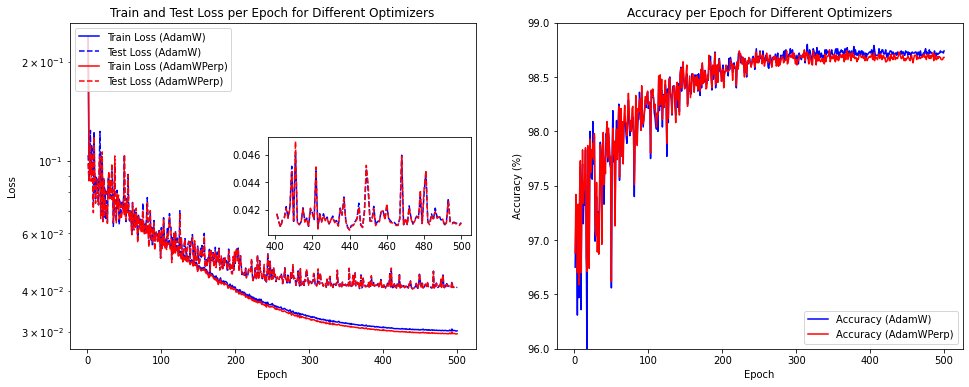

In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

N_later = 100  # Number of last epochs to focus on in the inset

# Initialize figure and axis
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# First subplot for Loss
axs[0].plot(range(1, EPOCHS + 1), params_epochs['train_W'], label='Train Loss (AdamW)', color='b', linestyle='-')
axs[0].plot(range(1, EPOCHS + 1), params_epochs['test_W'], label='Test Loss (AdamW)', color='b', linestyle='--')
axs[0].plot(range(1, EPOCHS + 1), params_epochs['train_perp'], label='Train Loss (AdamWPerp)', color='r', linestyle='-')
axs[0].plot(range(1, EPOCHS + 1), params_epochs['test_perp'], label='Test Loss (AdamWPerp)', color='r', linestyle='--')

axs[0].set_title('Train and Test Loss per Epoch for Different Optimizers')
axs[0].set_yscale('log')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='upper left')

# Adding inset
axins = inset_axes(axs[0], width="50%", height="30%", loc='center right')
axins.plot(range(EPOCHS - N_later + 1, EPOCHS + 1), params_epochs['test_W'][-N_later:], color='b', linestyle='--')
axins.plot(range(EPOCHS - N_later + 1, EPOCHS + 1), params_epochs['test_perp'][-N_later:], color='r', linestyle='--')
# axins.set_title(f'Last {N_later} Epochs (Test Loss)')
# axins.set_yscale('log')

# Second subplot for Accuracy
axs[1].plot(range(1, EPOCHS + 1), params_epochs['accuracy_W'], label='Accuracy (AdamW)', color='b', linestyle='-')
axs[1].plot(range(1, EPOCHS + 1), params_epochs['accuracy_perp'], label='Accuracy (AdamWPerp)', color='r', linestyle='-')

axs[1].set_title('Accuracy per Epoch for Different Optimizers')
axs[1].set_ylim([96, 99])  # Since you mentioned they both reach ~99%
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()

# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.show()


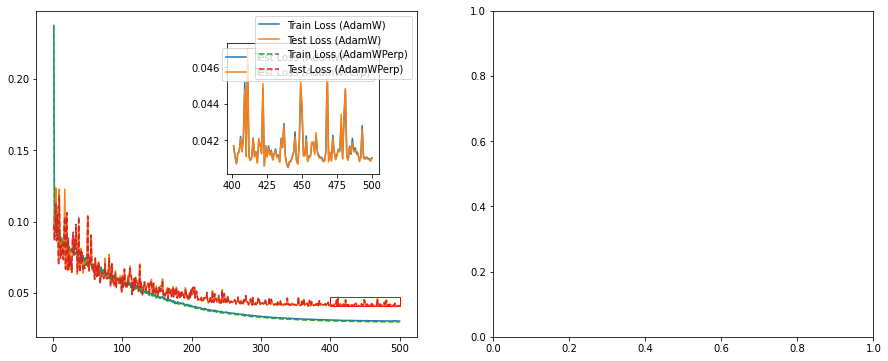

In [66]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# EPOCHS = 100
# N_later = 10  # Number of last epochs to focus on in the inset

# # Dummy data for demonstration
# params_epochs = {
#     'train_W': [1/(i+1) for i in range(EPOCHS)],
#     'test_W': [1/(i+1)**1.1 for i in range(EPOCHS)],
#     'train_perp': [1/(i+1)**1.2 for i in range(EPOCHS)],
#     'test_perp': [1/(i+1)**1.3 for i in range(EPOCHS)]
# }

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot losses
ax[0].plot(range(1, EPOCHS + 1), params_epochs['train_W'], label='Train Loss (AdamW)')
ax[0].plot(range(1, EPOCHS + 1), params_epochs['test_W'], label='Test Loss (AdamW)')
ax[0].plot(range(1, EPOCHS + 1), params_epochs['train_perp'], '--', label='Train Loss (AdamWPerp)')
ax[0].plot(range(1, EPOCHS + 1), params_epochs['test_perp'], '--', label='Test Loss (AdamWPerp)')

# Add inset plot for losses
axins = ax[0].inset_axes([0.5, 0.5, 0.4, 0.4])
axins.plot(range(EPOCHS - N_later + 1, EPOCHS + 1), params_epochs['test_W'][-N_later:], label='Test Loss (AdamW)')
axins.plot(range(EPOCHS - N_later + 1, EPOCHS + 1), params_epochs['test_perp'][-N_later:], label='Test Loss (AdamWPerp)')

# Add rectangle to indicate region of interest
rect = patches.Rectangle((EPOCHS - N_later, min(params_epochs['test_W'][-N_later:] + params_epochs['test_perp'][-N_later:])), N_later, max(params_epochs['test_W'][-N_later:] + params_epochs['test_perp'][-N_later:]) - min(params_epochs['test_W'][-N_later:] + params_epochs['test_perp'][-N_later:]), linewidth=1, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)

# Add legend to the inset
axins.legend(loc='upper right')

# Add legend to the main plot
ax[0].legend(loc='upper right')

# Add accuracy plot in the second panel
# ax[1].plot(...)  # Add your plotting code here

plt.show()
